Opening Up WARCs with warcio
===========================

This notebook contains examples of using the [`warcio`](https://github.com/webrecorder/warcio) Python library to open up and analyse WARC files. It's under active development, has few dependencies, supports Python 3, and is pretty straightforward to use. There's quite a few [other WARC implementations](https://www.archiveteam.org/index.php?title=The_WARC_Ecosystem), but `warcio` is a good one to start with.

[nbviewer](https://nbviewer.jupyter.org/github/ukwa/webarchiving-notebooks/blob/master/open-up-warcs-with-warcio.ipynb)

First, we need to make sure it's installed!

In [45]:
!pip install warcio svgwrite

     |████████████████████████████████| 71kB 5.1MB/s eta 0:00:01


To see what we can do, we need an example WARC to work with. To keep things simpler, we'll use a WARC file generated by trying to capture a single fairly-complicated web page (specifically, the Wikipedia home page during the [SOPA Blackout](https://en.wikipedia.org/wiki/Protests_against_SOPA_and_PIPA), see [here](https://github.com/ukwa/webarchive-test-suite/tree/master/wikipedia-sopa-blackout-2012) for more details).

You can override this with your own if you're running this notepad locally.

In [25]:
warc_file = 'example-warcs/sopa-wikipedia-homepage.warc.gz'

Now we can use the `warcio` library to open up this file, and iterate through the records.

In [104]:
from warcio.archiveiterator import ArchiveIterator

with open(warc_file, 'rb') as stream:
    iterator = ArchiveIterator(stream, check_digests=True)
    for record in iterator:
        print(iterator.offset, record.rec_type, record.length, record.content_type, record.format)
        if record.rec_type == 'request' or record.rec_type == 'response':
            print(record.rec_headers)
            print(record.http_headers)
            if record.rec_type == 'response':
                break
        

0 warcinfo 266 application/warc-fields warc
437 request 751 application/http;msgtype=request warc
WARC/1.0
WARC-Type: request
WARC-Record-ID: <urn:uuid:2C66DE4B-7C2A-4A18-A139-A33FC97FE1F4>
WARC-Date: 2012-01-18T14:31:20Z
Content-Length: 751
Content-Type: application/http;msgtype=request
WARC-Block-Digest: sha1:ES236IRD3H6BC4DFUBNVXATRIFFF6RTO
WARC-Target-URI: http://bits.wikimedia.org/en.wikipedia.org/load.php?debug=false&lang=en&modules=ext.UserBuckets%2CmarkAsHelpful%7Cext.UserBuckets.AccountCreationUserBucket%7Cext.articleFeedback.startup%7Cext.articleFeedbackv5.startup%7Cext.gadget.wmfFR2011Style%7Cjquery.autoEllipsis%2CcheckboxShiftClick%2CclickTracking%2CcollapsibleTabs%2Ccookie%2CdelayedBind%2ChighlightText%2Cjson%2CmakeCollapsible%2CmessageBox%2CmwPrototypes%2Cplaceholder%2Csuggestions%2CtabIndex%7Cmediawiki.language%2Cuser%2Cutil%7Cmediawiki.legacy.ajax%2Cmwsuggest%2Cwikibits%7Cmediawiki.page.ready&skin=vector&version=20120118T020454Z&*
WARC-Warcinfo-ID: <urn:uuid:E021A464-E2

The above is a very raw enumeration of the content. We need to come up with some meaningful analysis to experiment with.

One I'm interested in is 'mapping out' the WARC file, i.e. understanding the sequence of records, how large each is, and other basic facts about them.  To do this, we need the start and end positions of each WARC record, which is slightly clumsy to compute (as we have to keep track of the previous record offset as we stream through the file).

The following example shows how this can be done:

In [105]:
with open(warc_file, 'rb') as stream:
    iterator = ArchiveIterator(stream, check_digests=True)
    rec_index = 0
    rec_info = []
    for record in iterator:
        rec_info.insert(rec_index, {'type': record.rec_type, 'offset': iterator.offset} )
        if rec_index > 0:
            rec_info[rec_index - 1]['length'] = iterator.offset - rec_info[rec_index - 1 ]['offset']
        #print(iterator.offset, record.rec_type, record.length, record.content_type, record.format)
        #if record.rec_type == 'request' or record.rec_type == 'response':
        #    print(record.rec_headers)
        rec_index += 1
        
    # And add in the last length calculation:
    total_length = iterator.offset
    rec_info[rec_index - 1]['length'] = total_length - rec_info[rec_index - 1 ]['offset']
            
    print(len(rec_info))

164


The next step here is to work out some way of visualising this data. as a starter, if we make an [SVG](https://developer.mozilla.org/en-US/docs/Web/SVG) from the data we should be able to plot it here.

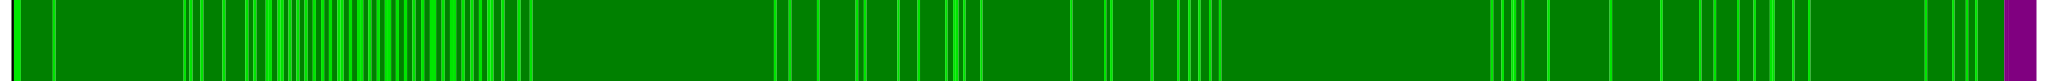

In [115]:
import svgwrite
from IPython.display import SVG

svg_file = 'warc-map.svg'

colourmap = {
    'warcinfo': svgwrite.rgb(0, 0, 0, '%'),      # Black
    'request': svgwrite.rgb(0, 90, 0, '%'),      # Bright Green
    'response': svgwrite.rgb(0, 50, 0, '%'),     # Dark Green
    'revisit': svgwrite.rgb(0, 20, 0, '%'),      # Very Dark Green
    'resource': svgwrite.rgb(50, 0, 50, '%'),    # Purple
    'metadata': svgwrite.rgb(0, 0, 100, '%'),    # Bright Blue
    'conversion': svgwrite.rgb(100, 0, 0, '%'),  # Bright Red
    'continuation': svgwrite.rgb(100, 0, 0, '%') # Bright Red
}

dwg = svgwrite.Drawing(svg_file, profile='full')
block_height = total_length/25
dwg.viewbox(width=total_length, height=block_height)
for ri in rec_info:
    r = dwg.add(dwg.rect((ri['offset'],0), (ri['length'],block_height), fill=colourmap[ri['type']], stroke_width=0))
    r.set_desc("%s %i-%i" % (ri['type'], ri['offset'], ri['offset']+ ri['length']))
dwg.save()

SVG(filename=svg_file)

Which looks pretty nice! It wouldn't be clear that clear if different record types were next to eachother, but most tools will write requests and responses together, so it's generall clear in practice.